## DEPENDENCIES

Uncomment the following pip commands to install the necessary dependencies if it is the first time run.
Then, reset the runtime and do not run the pip installs again.

In [ ]:
# !pip install --user -U nltk
# !pip install -U deep-translator
# !pip install tqdm_notebook
# !pip install pyldavis
# !pip install vadersentiment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from deep_translator import GoogleTranslator
from matplotlib import pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import PorterStemmer
import gensim
import pyLDAvis
import pyLDAvis.gensim
import re
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## IMPORT DATA

In [ ]:
df = pd.read_excel("Viva-Tec-data.xlsx", sheet_name="Manage my booking")
df.rename({'_C_mo_podemos_mejorar_': 'Comment'}, axis=1, inplace=True)
df = df.iloc[:200,:] # Daily average is 66
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,nps,Comment
0,2023-03-01 03:34:41,6,No hay claridad en la pagina. Las opciones est...
1,2023-03-01 02:18:07,1,no cobrando doblemente la seleccion de asiento...
2,2023-02-28 23:50:15,6,NO ES CLARO.
3,2023-02-28 23:32:35,7,SON DEMASIADOS CARGOS ADICIONALES
4,2023-02-28 20:44:16,0,El equipaje de la tarifa smart ya estaba pagad...
...,...,...,...
61,2023-02-25 04:33:33,8,trabajar mas
62,2023-02-25 03:20:24,8,cobra equipaje de mas
63,2023-02-25 01:42:40,0,No funciona bien l apagina
64,2023-02-25 01:11:11,8,el proceso de pago cuando se hace el cambio es...


## EXPLORATION

In [ ]:
unique = []

for i, text in enumerate(df["Comment"]):
  text = str(text).lower()
  x = len(text.split())
  if x == 1 and len(text) < 4:
    if text not in unique:
      unique.append(text)

print(len(unique))
print(unique)

2
['si', 'ss']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NPS Score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([16.,  3.,  5.,  1.,  0.,  1.,  7., 10.,  3., 20.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

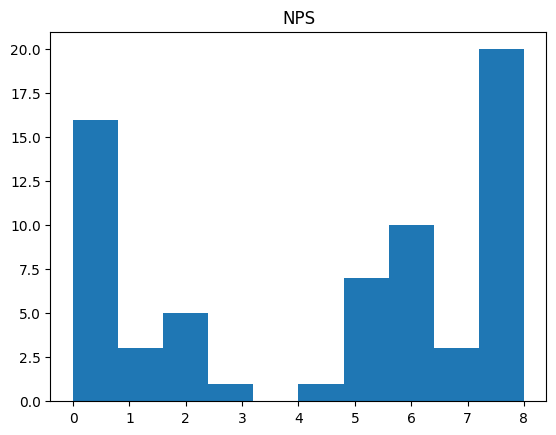

In [ ]:
plt.title("NPS")
plt.hist(df["nps"])

In [ ]:
promoters_count = len(df[df.nps >= 9])
promoters = promoters_count / len(df)

detractors_count = len(df[df.nps <= 6])
detractors = detractors_count / len(df)

nps_score = (promoters - detractors) * 100
print("Weighted NPS score = {}".format(nps_score))
print("NPS Score = %promoters(10-9) - %ditractor(>6)")

Weighted NPS score = -65.15151515151516
NPS Score = %promoters(10-9) - %ditractor(>6)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### TIME

In [ ]:
def removeTime(row):
  return row.date()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_time = df.copy()
df_time['Date'] = pd.to_datetime(df_time.Date)
df_time['Date'] = df_time.Date.apply(removeTime)
df_time = df_time.groupby(['Date']).count()
df_time.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5, 2)

In [ ]:
df_time = df_time.drop("Comment", axis=1)
df_time.rename({'nps': 'Reviews'}, axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-888df913a8a3>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)


[Text(19413.0, 0, '02-25 00'),
 Text(19413.5, 0, '02-25 12'),
 Text(19414.0, 0, '02-26 00'),
 Text(19414.5, 0, '02-26 12'),
 Text(19415.0, 0, '02-27 00'),
 Text(19415.5, 0, '02-27 12'),
 Text(19416.0, 0, '02-28 00'),
 Text(19416.5, 0, '02-28 12'),
 Text(19417.0, 0, '03-01 00')]

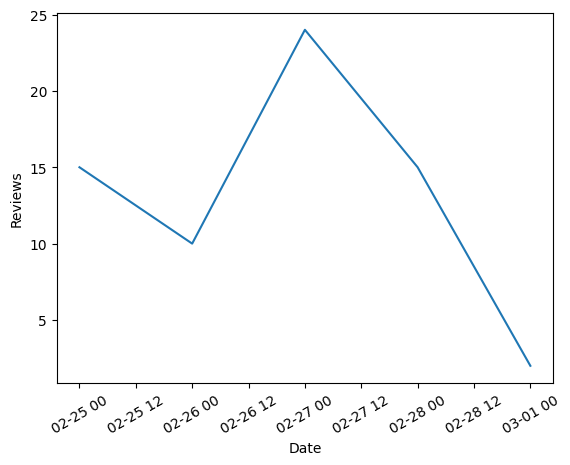

In [ ]:
line_plot = sns.lineplot(data=df_time, x="Date", y="Reviews")
line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)

In [ ]:
daily_average = sum(df_time.Reviews)/df_time.shape[0]
daily_average

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13.2

## PRE-PROCESSING

###Filter: spanish

In this step any entries below 3 characters are inspected to certify they contain relevant information and not just trash data like empty text, periods or such. Additionally, the data can contain irregular characters such as emojis or emoticons that can convey relevant customer data. These responses are mapped to equivalent emotions to be analyzed by sentiment. This section also calcultes the mean length of entries and removes empty or useless data.

In [ ]:
avg = 0
max_len = 0
min_len = 1000000

# Declare tokens of lenght less than 3 that are considered relevant feedback
desired_tokens = ["si", "no", "ok"]
# Converte emojis and emoticons to quantifiable and manageable data based on type of reaction
happy_emojis = [":)", "(:", "(;", '👍', ";)", ";D", ":D", "😊", "=)", "😇", "👌🏻"]
sad_emojis = ["=(", ":/", "):", ":(", ");", ";(", "🙁","😭","😢"]
drop_list = []

for i, text in enumerate(df["Comment"]):
  text = str(text).lower()
  x = len(text.split())
  if text in happy_emojis:
    df.loc[i, "Comment"] = "feliz"
  elif text in sad_emojis:
    df.loc[i, "Comment"] = "triste"
  elif x == 1 and len(text) < 3 and text not in desired_tokens:
      drop_list.append(i)
      continue
  avg += x
  if x > max_len:
    max_len = x
  elif x < min_len:                                     
    min_len = x

avg /= len(df["Comment"])
print("LENGTH\nAvg = {} / Max {} / Min {}\n".format(avg, max_len, min_len))
print("DROP\nDrop {} invalid reviews".format(len(drop_list)))
print("NaN comments dropped {}".format(df['Comment'].isna().sum()))

LENGTH
Avg = 13.818181818181818 / Max 76 / Min 1

DROP
Drop 1 invalid reviews
NaN comments dropped 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Remove trash entries or nonsensical input
df = df.drop(labels=drop_list)
df = df.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Translation

The processed data is loaded into the Google Translate library to translate all comments from spanish to english. Any comments written in english are skipped. This is done because the sentiment analysis models are trained using text in english.

In [ ]:
def translate(row):
  r = str(row)
  try:
    t  = GoogleTranslator(source='es', target='en').translate(str(r))
    return t
  except:
    return "NVT"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['translation'] = df.Comment.progress_apply(translate)
df = df.drop(axis = 1, labels = 'Comment') 
df.rename({'translation': 'Comment'}, axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/65 [00:00<?, ?it/s]

###Filter: english

The translated model is once again filtered to ensure only relevant entries are considered and included in the following sentiment analysis and topic modeling. It is important to note that for sentiment analysis, the processed data is input directly with punctuation and capitalization in order to extract the most accurate interpretation. On the other hand, topic modeling is done with the simplified, tokenized words in order to focus entirely on the core ideas.

In [ ]:
avg = 0
max_len = 0
min_len = 1000000

# Declare tokens of lenght less than 3 that are considered relevant feedback
desired_tokens = ["no", "ok", "wow", "lol", "all", "wow", "bye", "sad"]
# Converte emojis and emoticons to quantifiable and manageable data based on type of reaction
happy_emojis = [":)", "(:", "(;", '👍', ";)", ";D", ":D", "😊", "=)", "😇", "👌🏻"]
sad_emojis = ["=(", ":/", "):", ":(", ");", ";(", "🙁","😭","😢"]
drop_list = []

for i, text in enumerate(df["Comment"]):
  text = str(text).lower()
  x = len(text.split())
  if text in happy_emojis:
    df.loc[i, "Comment"] = "feliz"
  elif text in sad_emojis:
    df.loc[i, "Comment"] = "triste"
  elif x == 1 and len(text) < 4 and text not in desired_tokens:
      drop_list.append(i)
      continue
  avg += x
  if x > max_len:
    max_len = x
  elif x < min_len:                                     
    min_len = x

avg /= len(df["Comment"])
print("LENGTH\nAvg = {} / Max {} / Min {}\n".format(avg, max_len, min_len))
print("DROP\nDrop {} invalid reviews".format(len(drop_list)))
print("NaN comments dropped {}".format(df['Comment'].isna().sum()))

LENGTH
Avg = 14.96923076923077 / Max 83 / Min 1

DROP
Drop 0 invalid reviews
NaN comments dropped 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenization & Remove Stopwords

In order to perform topic modeling, the processed comments are tokenized (separated into individual words) and the stop words are removed. Stop words are unnecesary connecting words, prepositions or other words without key value. These are removed to get a clearer understanding of the core ideas included in the dataset. 

In [ ]:
# Get list of stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('easy')

df_stop = df.copy()
stop_series = []
filtered = []

# Use regex to remove punctuation and tokenize
for i, text in enumerate(df['Comment']):
  text = re.sub(r'[^\w\s]', '', text)
  word_tokens = str(text).split()

  filtered = []
  for w in word_tokens:
    if w.lower() not in stop_words:
      filtered.append(w.lower())
  
  stop_series.append(filtered)

df_stop['Filtered'] = stop_series

df_stop

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,nps,Comment,Filtered
0,2023-03-01 03:34:41,6,There is no clarity on the page. The options a...,"[clarity, page, options, jumbled, disarray]"
1,2023-03-01 02:18:07,1,not double charging for seat selection when ch...,"[double, charging, seat, selection, changing, ..."
2,2023-02-28 23:50:15,6,IT'S NOT CLEAR.,[clear]
3,2023-02-28 23:32:35,7,THESE ARE TOO MANY ADDITIONAL CHARGES,"[many, additional, charges]"
4,2023-02-28 20:44:16,0,"The smart fare baggage was already paid for, a...","[smart, fare, baggage, already, paid, making, ..."
...,...,...,...,...
61,2023-02-25 04:33:33,8,Work more,[work]
62,2023-02-25 03:20:24,8,charge extra baggage,"[charge, extra, baggage]"
63,2023-02-25 01:42:40,0,The page does not work well,"[page, work, well]"
64,2023-02-25 01:11:11,8,The payment process when the change is made is...,"[payment, process, change, made, somewhat, con..."


## Topic Modeling

Topic modeling analyzes how often different words appear together and creates topics based on the frequency of specific words appearing together. In order to do this, the previously tokenized words are lemmatized in order to remove the temporal tense of the word, as well as removing any words smaller than 2 letters. These words are then used to create a dictionary of the different relations between words, which is then analyzed using a Latent Dirichlet Allocation algorithm to extract the desired topics.

In [ ]:
corpus = []
stem = PorterStemmer()
lem = nltk.WordNetLemmatizer()

for tokens in df_stop['Filtered']:
  words = [lem.lemmatize(w.lower()) for w in tokens if len(w) > 2]

  corpus.append(words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics = 8,
                                       id2word = dic,
                                       passes = 5,
                                       workers = 2)
lda_model.show_topics() 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.045*"seat" + 0.045*"change" + 0.030*"time" + 0.030*"page" + 0.023*"charge" + 0.023*"pay" + 0.023*"flight" + 0.015*"cannot" + 0.015*"error" + 0.015*"wanted"'),
 (1,
  '0.044*"change" + 0.033*"made" + 0.024*"charge" + 0.022*"mistake" + 0.022*"system" + 0.022*"seat" + 0.022*"extra" + 0.012*"many" + 0.012*"pay" + 0.012*"changing"'),
 (2,
  '0.028*"well" + 0.028*"record" + 0.028*"accommodation" + 0.028*"address" + 0.028*"done" + 0.028*"understood" + 0.028*"complicated" + 0.004*"staff" + 0.004*"want" + 0.003*"say"'),
 (3,
  '0.052*"change" + 0.035*"make" + 0.019*"without" + 0.019*"cost" + 0.019*"respect" + 0.019*"page" + 0.019*"airline" + 0.019*"lot" + 0.019*"happy" + 0.019*"ever"'),
 (4,
  '0.029*"seat" + 0.020*"price" + 0.020*"selection" + 0.020*"problem" + 0.020*"changing" + 0.019*"want" + 0.019*"staff" + 0.010*"cost" + 0.010*"per" + 0.010*"stop"'),
 (5,
  '0.085*"charge" + 0.032*"baggage" + 0.023*"made" + 0.023*"time" + 0.023*"change" + 0.012*"additional" + 0.012*"page" + 0.012

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.080167  0.003356       1        1  22.293775
4     -0.023815 -0.167139       2        1  16.212689
7     -0.131086  0.076318       3        1  14.387026
1      0.058344  0.000864       4        1  13.338026
5      0.108336  0.078469       5        1  13.321096
6     -0.085594  0.034699       6        1  11.488527
3      0.006679 -0.008770       7        1   6.537579
2     -0.013029 -0.017796       8        1   2.421282, topic_info=         Term       Freq      Total Category  logprob  loglift
13     charge   9.000000   9.000000  Default  30.0000  30.0000
18     change  14.000000  14.000000  Default  29.0000  29.0000
22       paid   5.000000   5.000000  Default  28.0000  28.0000
11      clear   3.000000   3.000000  Default  27.0000  27.0000
59       make   2.000000   2.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
154     force   0.036450   2.004086   Topic8  -5.7068  -0.2861
5    changing   0.036914   2.587241   Topic8  -5.6942  -0.5289
48    airline   0.036799   2.495064   Topic8  -5.6973  -0.4957
59       make   0.036621   2.892772   Topic8  -5.7022  -0.6485
77    luggage   0.036494   3.377807   Topic8  -5.7056  -0.8069

[366 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
221       6  0.833124  39800mxn
222       6  0.833124  70000mxn
185       4  0.813814      able
186       4  0.813814    access
187       4  0.813814   account
...     ...       ...       ...
238       5  0.507946      work
65        7  0.923957     worst
174       6  0.833125     worth
95        3  0.800891     would
199       2  0.785813      yeah

[345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 8, 2, 6, 7, 4, 3])

# VADER

In [ ]:
def getSentiment(comment):
  try:
    # Create the object analyzer
    sent_obj = SentimentIntensityAnalyzer()
    #Create the dictionary with the polarity values for the sentence
    sent_dictionary = sent_obj.polarity_scores(comment)
    #Return the compounded sentiment value
    return(sent_dictionary['compound'])
  except:
    print(comment)
    return -10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['vader_sentiment'] = df.Comment.progress_apply(getSentiment)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
dates = df.copy()
dates['Date'] = pd.to_datetime(dates.Date)
dates['Date'] = dates.Date.apply(removeTime)
dates.columns
dates = dates.drop(labels= ['Comment', 'nps'], axis = 1)
dates = dates.groupby(['Date']).mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-451280906579>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)


[Text(19413.0, 0, '02-25 00'),
 Text(19413.5, 0, '02-25 12'),
 Text(19414.0, 0, '02-26 00'),
 Text(19414.5, 0, '02-26 12'),
 Text(19415.0, 0, '02-27 00'),
 Text(19415.5, 0, '02-27 12'),
 Text(19416.0, 0, '02-28 00'),
 Text(19416.5, 0, '02-28 12'),
 Text(19417.0, 0, '03-01 00')]

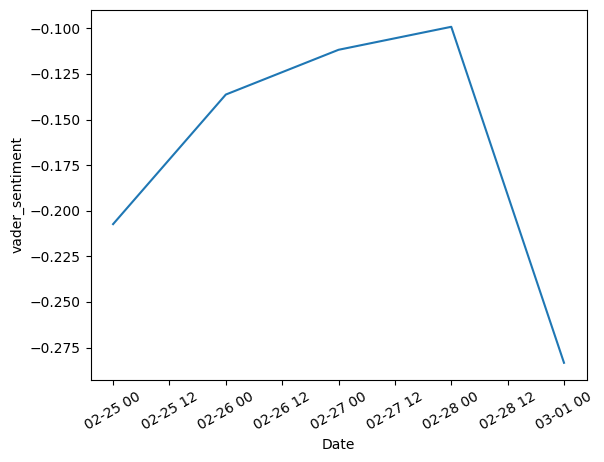

In [ ]:
line_plot = sns.lineplot(data=dates, x="Date", y="vader_sentiment")
line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=30)